In [1]:
import tejapi
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

tejapi.ApiConfig.api_key  = "Your Key"
tejapi.ApiConfig.api_base = "https://api.tej.com.tw"
tejapi.ApiConfig.ignoretz = True

In [2]:
Olympic_opening =  [pd.Timestamp('2012-07-27', tz = 'UTC'),
                    pd.Timestamp('2016-08-05', tz = 'UTC'),
                    pd.Timestamp('2021-07-23', tz = 'UTC')
                    ]

Olympic_ending =   [pd.Timestamp('2012-08-12', tz = 'UTC'),
                    pd.Timestamp('2016-08-21', tz = 'UTC'),
                    pd.Timestamp('2021-08-08', tz = 'UTC')
                    ]

count = 30
Olympic = []
for x in range(len(Olympic_opening)):
    if int(str(count)[-1]) == 1:
        count_session = str(count) + 'st'
        session_of_Olympic = ('{}_Olympic' .format(count_session))
        count += 1
        Olympic.append(session_of_Olympic)
    elif int(str(count)[-1]) == 2:
        count_session = str(count) + 'nd'
        session_of_Olympic = ('{}_Olympic' .format(count_session))
        count += 1
        Olympic.append(session_of_Olympic)
    elif int(str(count)[-1]) == 3:
        count_session = str(count) + 'rd'
        session_of_Olympic = ('{}_Olympic' .format(count_session))
        count += 1
        Olympic.append(session_of_Olympic)
    else:
        count_session = str(count) + 'th'
        session_of_Olympic = ('{}_Olympic' .format(count_session))
        count += 1
        Olympic.append(session_of_Olympic)

Olympic_dict = dict(zip(Olympic, zip(Olympic_opening, Olympic_ending)))

In [3]:
Olympic_df = pd.DataFrame.from_dict(Olympic_dict,  orient='index', columns=['start_date', 'end_date'])
Olympic_df['Year'] = [str(Date)[:4] for Date in Olympic_df['start_date']]
Olympic_df

,start_date,end_date,Year
30th_Olympic,2012-07-27 00:00:00+00:00,2012-08-12 00:00:00+00:00,2012
31st_Olympic,2016-08-05 00:00:00+00:00,2016-08-21 00:00:00+00:00,2016
32nd_Olympic,2021-07-23 00:00:00+00:00,2021-08-08 00:00:00+00:00,2021


In [4]:
def get_TAIEX(gte , lte):
    data = tejapi.get('TWN/APRCD1',
                        coid = 'Y9999',
                        mdate = {'gte':gte, 'lte':lte},
                        # 證券代碼、日期、收盤價(元)、報酬率%
                        opts = {'columns':['coid', 'mdate', 'close_adj', 'roi']},
                        paginate = True,
                        )
    return data

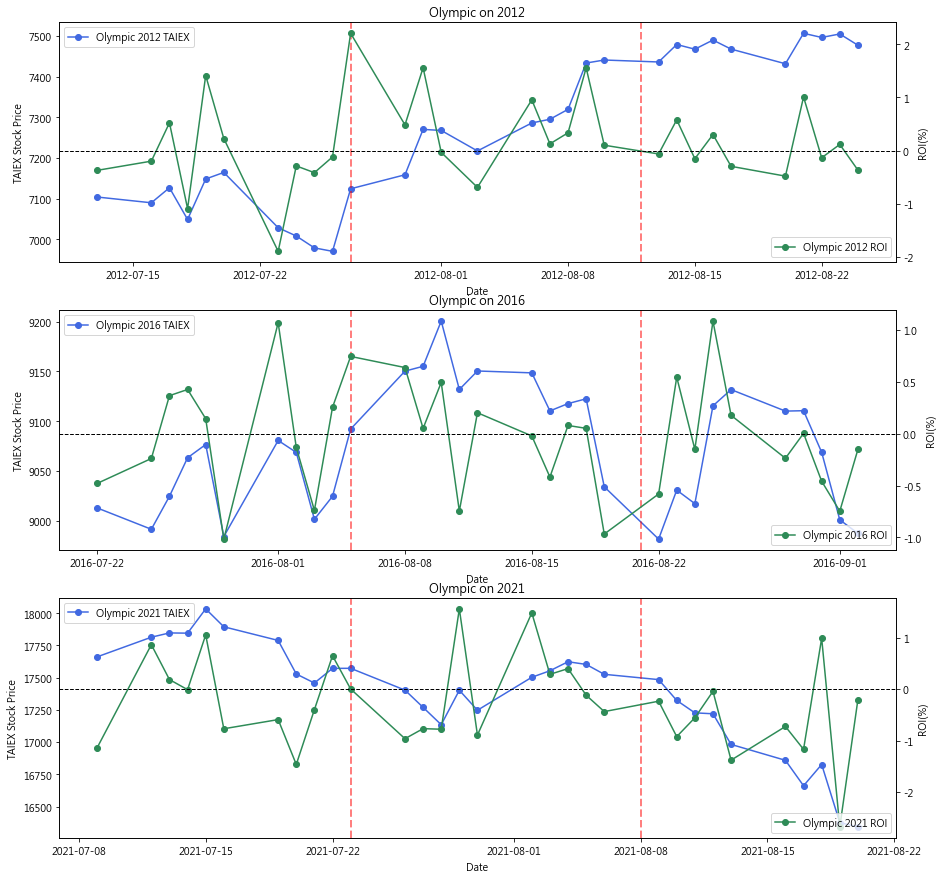

In [5]:
start = []
end = []
TAIEX_df = pd.DataFrame(columns=['coid', 'mdate', 'close_adj', 'roi'])  # 設置一個空的df
for key, value in Olympic_dict.items():
    start_date = str(value[0] - pd.DateOffset(weeks=2))[:10]  # 開幕日網前抓兩周
    end_date = str(value[1] + pd.DateOffset(weeks=2))[:10]  # 閉幕日網後抓兩周
    Olympic_data = get_TAIEX(start_date, end_date)  # 取得加權指數(Y9999)股價
    TAIEX_df = pd.concat([TAIEX_df, Olympic_data], ignore_index=True)   # 將抓回來的股價資料合併在起初設置的df
    start.append(start_date)
    end.append(end_date)

TAIEX_df['Year'] = [str(Date)[:4] for Date in TAIEX_df['mdate']]
Olympic_year = TAIEX_df['Year'].unique()  # unique可以確保股價資料年分與奧運年分是一樣的年分

fig, axs = plt.subplots(len(Olympic_year), 1, figsize=(15, 5 * len(Olympic_year)), sharex=False)

# 將抓回來的股價資料畫在圖上
for i, year in enumerate(Olympic_year):
    Olympic = TAIEX_df[TAIEX_df['Year'] == year]
    axs[i].plot(Olympic['mdate'].to_numpy(), Olympic['close_adj'].to_numpy(), color='royalblue', marker='o', label=f"Olympic {year} TAIEX", zorder = 2)
    ax2 = axs[i].twinx()  # 設置雙軸
    ax2.plot(Olympic['mdate'].to_numpy(), Olympic['roi'].to_numpy(), color='seagreen', marker='o', label=f'Olympic {year} ROI', zorder = 1)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)  # 畫出"零"線
    ax2.set_ylabel('ROI(%)')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('TAIEX Stock Price')
    axs[i].legend(loc='upper left')
    ax2.legend(loc='lower right')
    # 將開幕日與閉幕日畫出來
    for start_day, end_day, Oyear in zip(Olympic_df['start_date'], Olympic_df['end_date'], Olympic_df['Year']):
        if Oyear == year:
            axs[i].axvline(x=start_day, color='r', linestyle='--', alpha=0.5, linewidth=2)
            axs[i].axvline(x=end_day, color='r', linestyle='--', alpha=0.5, linewidth=2)
            axs[i].set_title(f"Olympic on {Oyear}")

### 面板產業(LCD面板) - 2409(友達-AUO) , 3481(群創-INX) , 6116(彩晶-Hannstar)

### 成衣紡織(成衣製造、聚酯絲棉) - 1476(儒鴻-FENC) , 1477(聚陽-ECLAT) , 1402(遠東新-Makalot)

### 製鞋(鞋及旅行箱) - 9904(寶成-FT) , 9910(豐泰-PCC) , 9802(鈺齊-KY-Fulgent Sun)

### 運動器材(健身器材、自行車) - 1515(力山-Rexon) , 1736(喬山-JHT) , 9921(巨大-Giant)

### 旅遊(旅行社) - 2731(雄獅-Liontravel) , 5706(鳳凰-PHX Tour)

### 航空(空運業) - 2610(華航-CAL) , 2618(長榮航-EVAAIR)

In [6]:
def get_data_industry(*coid):  # *coid的可以輸入list型態的變數
    data_industry = tejapi.get('TWN/AIND',
                                coid = coid,
                                # 證券代碼、公司中文簡稱、TEJ子產業_名稱(中)	
                                opts = {'columns':['coid', 'inamec', 'tejinm3_c']},
                                paginate = True)
    data_industry = data_industry.rename(columns={"inamec":"Company_c", "tejinm3_c": "Industry_c"}).reset_index().drop(columns=['None'])
    return data_industry

In [6]:
def get_data_idustry(*coid):
    data_industry = tejapi.get('TWN/AIND',
                                coid = coid,
                                mkt = {'OTC', 'TSE'},
                                opts = {'columns':['coid', 'mkt', 'inamec', 'inamee', 'tejinm3_c', 'tejinm3_e']},
                                paginate = True)
    data_industry = data_industry.rename(columns={"tejinm3_c": "Industry_c" , "tejinm3_e": "Industry_e"}).reset_index().drop(columns=['None'])
    return data_industry

In [7]:
industry_dict = {
    'LCD_panel': ['2409', '3481', '6116'],
    'clothes': ['1402', '1476', '1477'],
    'shoes': ['9802', '9904', '9910'],
    'fitness_bike': ['1515', '1736', '9921'],
    'travel': ['2731', '5706'],
    'aviation': ['2610', '2618']
}

In [8]:
def get_stock_price(gte , lte , *coid):
    data = tejapi.get('TWN/APRCD1',
                        coid = coid,
                        mdate = {'gte':gte, 'lte':lte},
                        # 證券代碼、日期、收盤價(元)
                        opts = {'columns':['coid', 'mdate', 'close_adj']},
                        paginate = True,
                        )
    return data

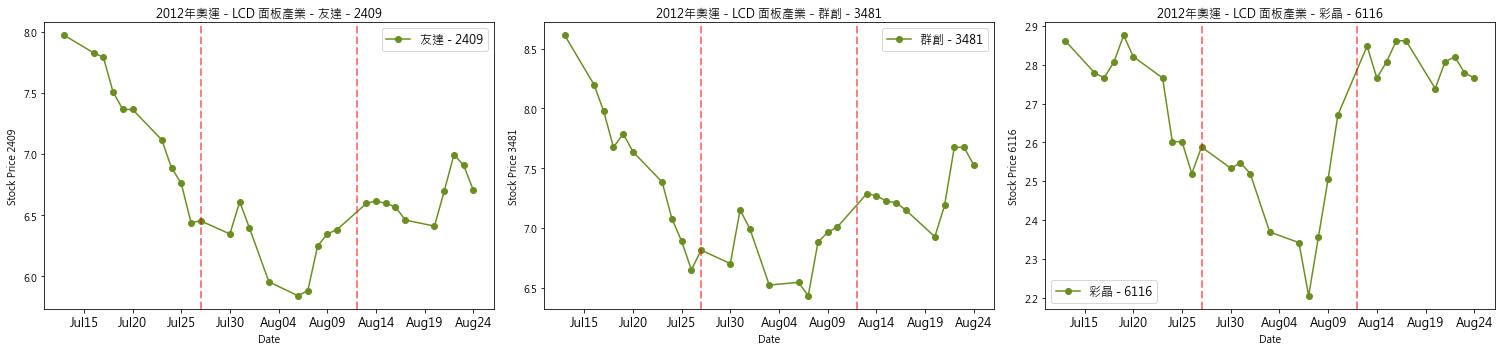

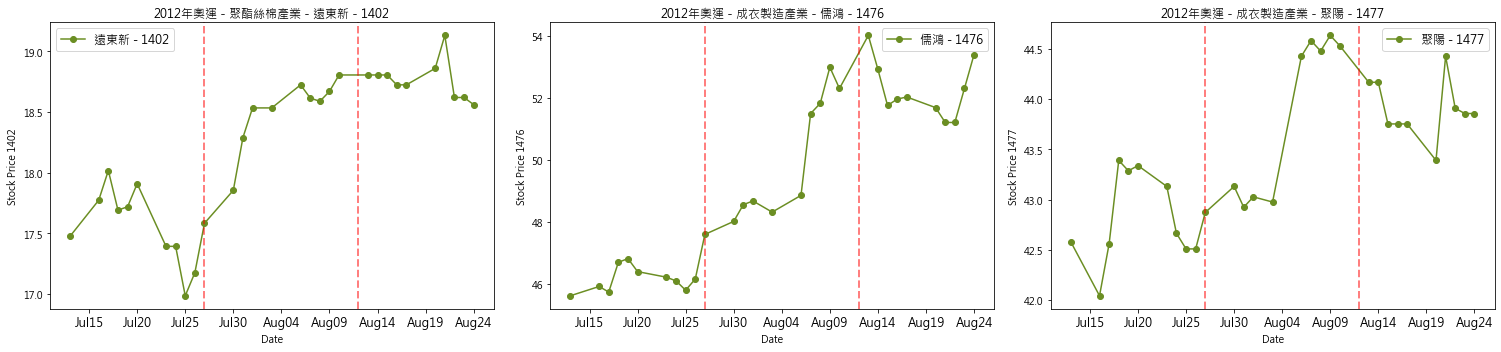

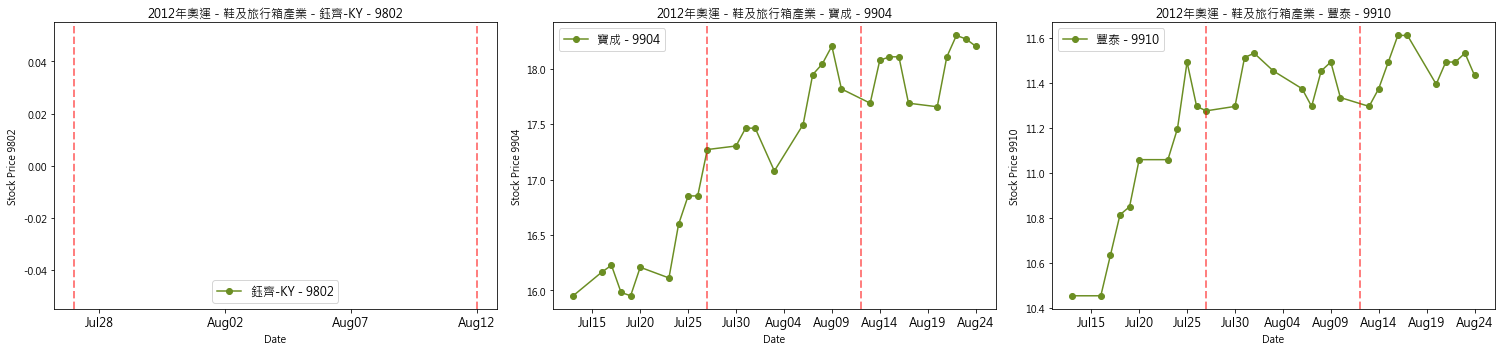

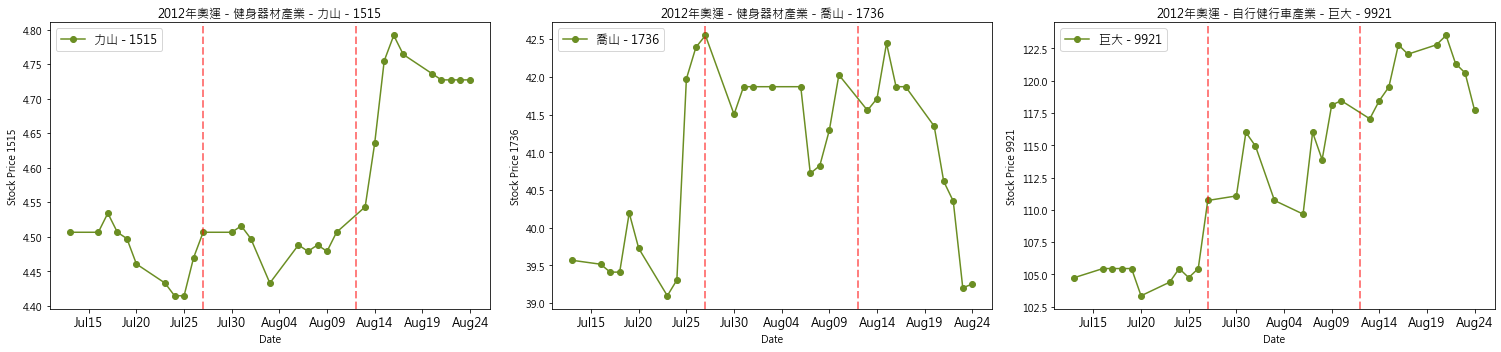

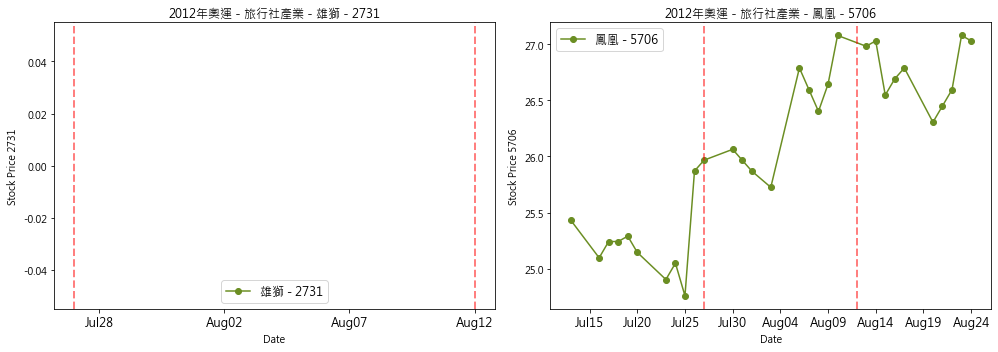

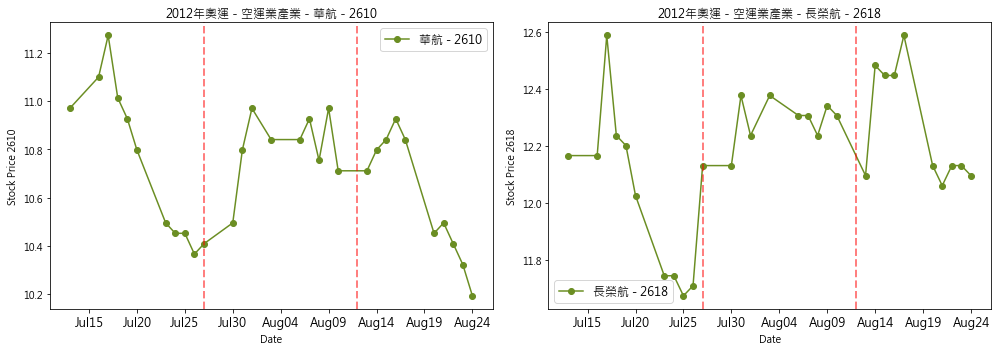

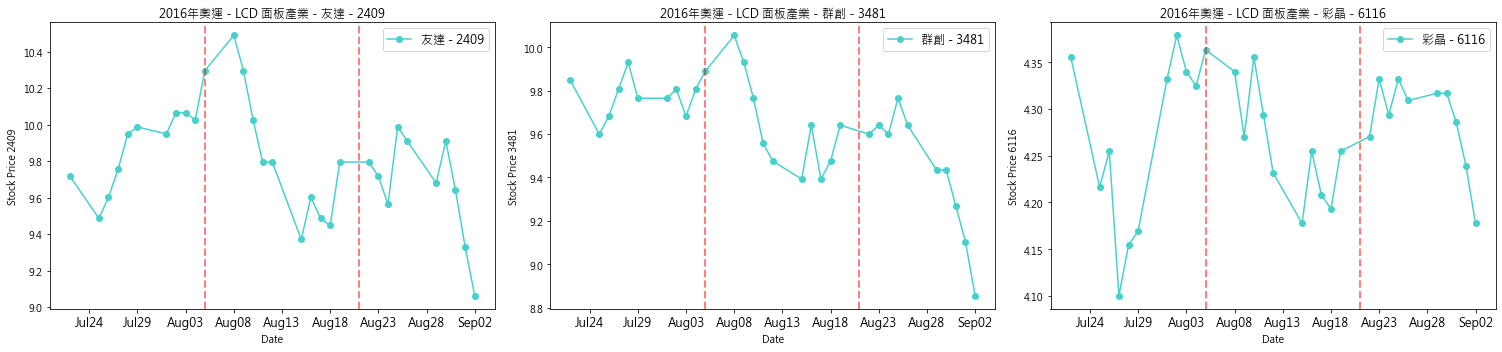

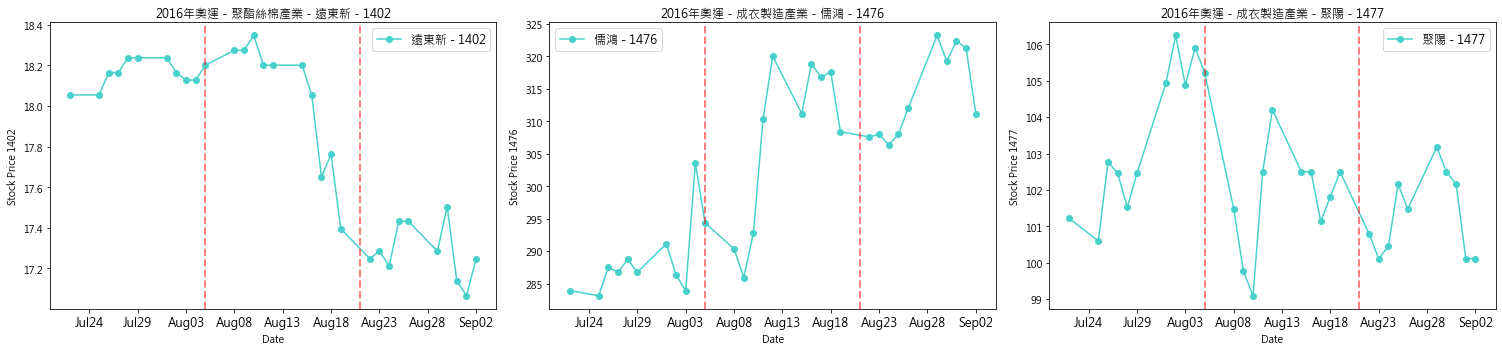

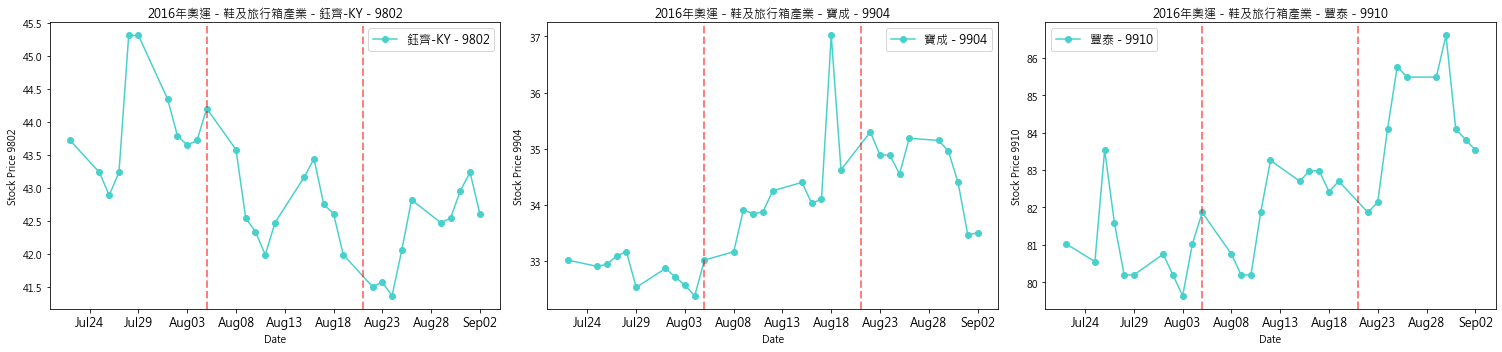

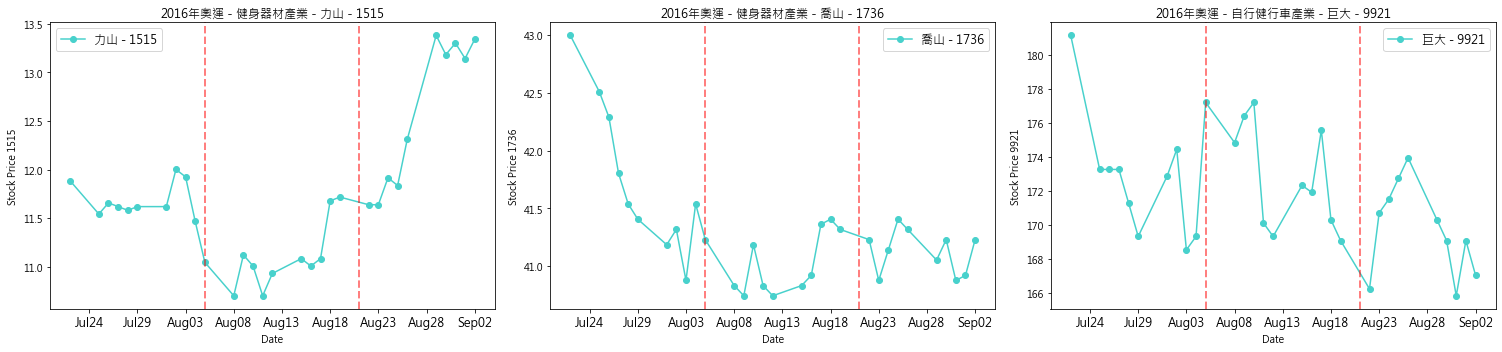

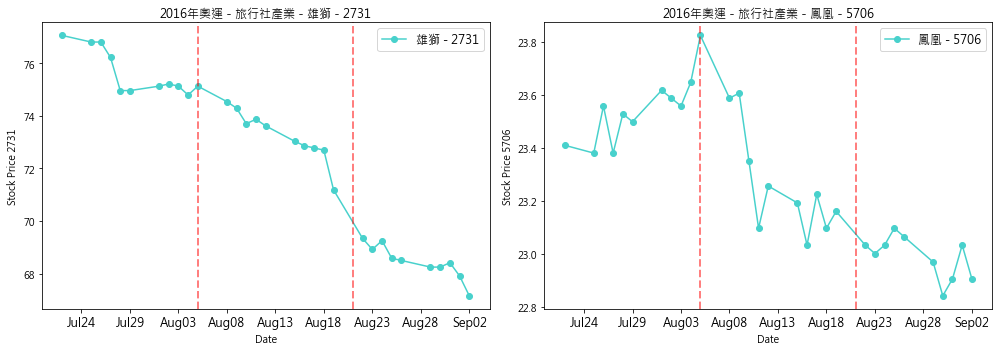

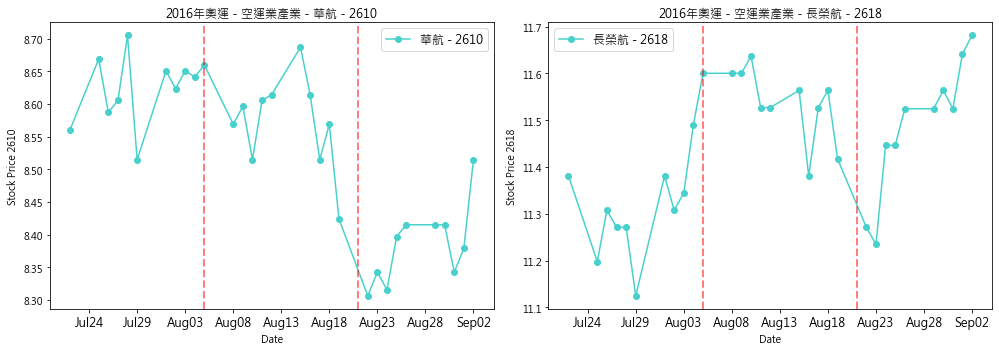

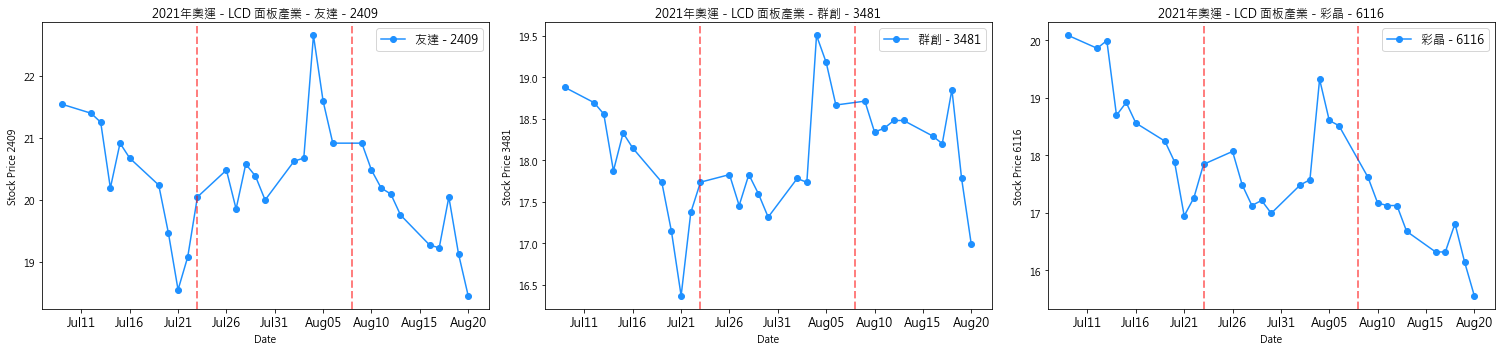

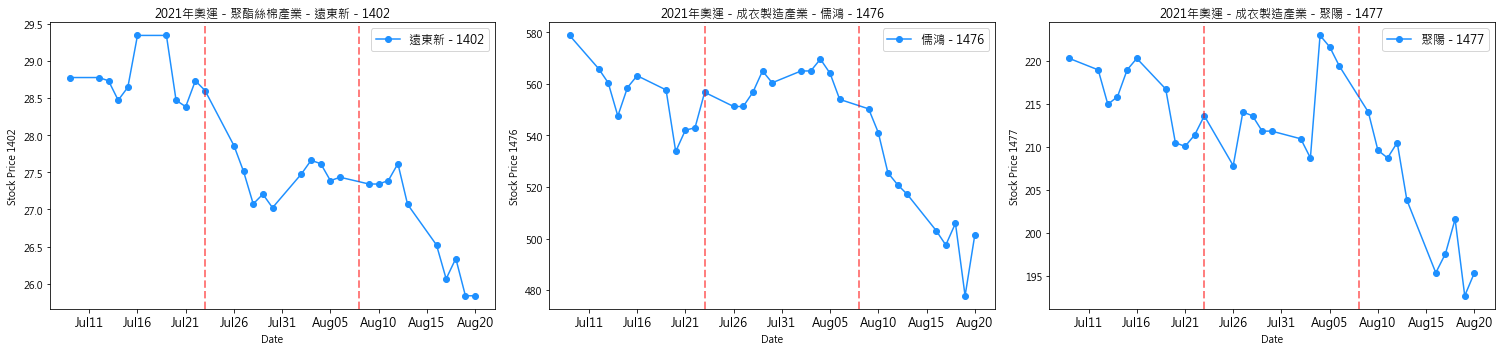

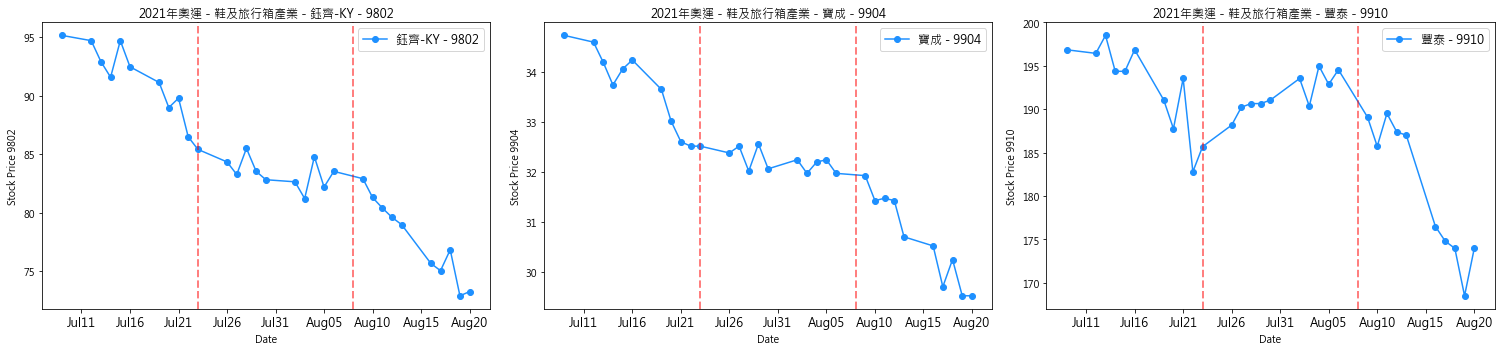

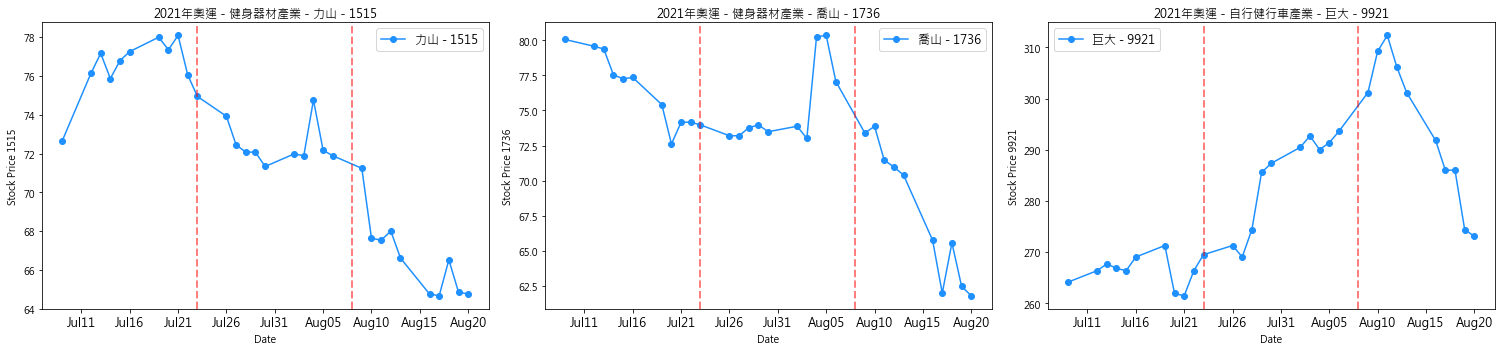

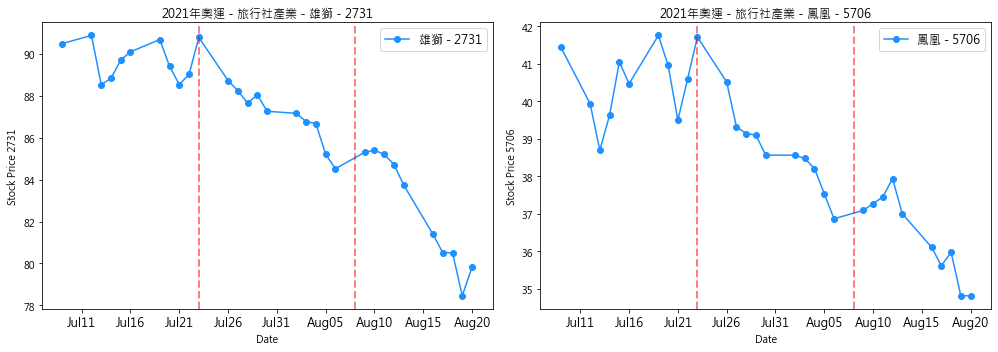

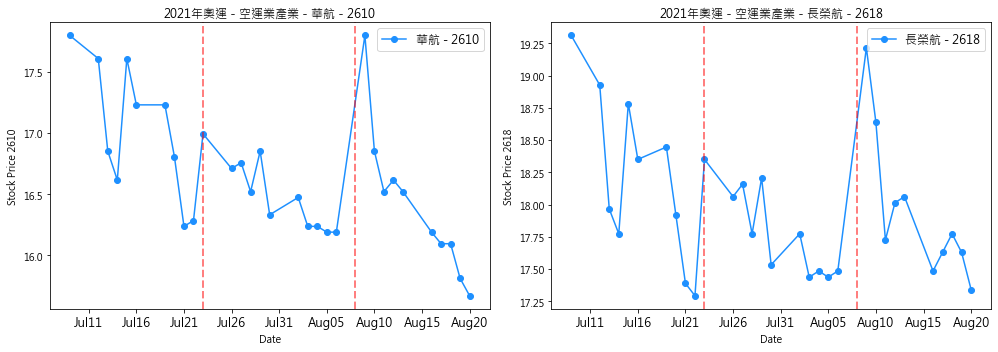

In [9]:
for key, value in Olympic_dict.items():
    start_date = str(value[0] - pd.DateOffset(weeks=2))[:10]  # 開幕日網前抓兩周
    end_date = str(value[1] + pd.DateOffset(weeks=2))[:10]  # 閉幕日網前抓兩周
    for industry, icoid in industry_dict.items():
        stock_data = get_stock_price(start_date, end_date, icoid)  # 取得股價資料
        stock_data['mdate'] = pd.to_datetime(stock_data['mdate'])
        industry_name = get_data_industry(industry_dict[industry])  # 取得產業名稱
        fig, axes = plt.subplots(nrows=1, ncols=len(icoid), figsize=(7*len(icoid), 5), squeeze=False, layout="constrained")
        for i, coid in enumerate(icoid):
            data = stock_data[stock_data['coid'] == coid]
            company_c = industry_name.loc[i, 'Company_c']
            industry_c = industry_name.loc[i, 'Industry_c']
            event_year = start_date[:4]
            # 不同年分設置不同顏色
            if event_year == '2012':
                color = 'olivedrab'
            elif event_year == '2016':
                color = 'mediumturquoise'
            elif event_year == '2021':
                color = 'dodgerblue'
            # 將抓回來的股價資料畫在圖上
            axes[0,i].plot(data['mdate'].to_numpy(), data['close_adj'].to_numpy(), color=color, label=f'{company_c} - {coid}', marker='o')
            axes[0,i].set_xlabel('Date')
            axes[0,i].set_ylabel(f'Stock Price {coid}')
            axes[0,i].legend(fontsize=12)
            axes[0,i].xaxis.set_major_locator(mdates.DayLocator(interval=5))  # 設置x軸時間，每5天顯示日期
            axes[0,i].xaxis.set_major_formatter(mdates.DateFormatter('%b%d'))  # 日期顯示月日
            axes[0,i].tick_params(axis='x', which='major', labelsize=12)
            for start_day, end_day, Oyear in zip(Olympic_df['start_date'], Olympic_df['end_date'], Olympic_df['Year']):
                if Oyear == str(stock_data['mdate'].loc[0])[:4]:
                    axes[0,i].axvline(x=start_day, color='r', linestyle='--', alpha=0.5, linewidth=2)
                    axes[0,i].axvline(x=end_day, color='r', linestyle='--', alpha=0.5, linewidth=2)
                    axes[0,i].set_title(f"{Oyear}年奧運－{industry_c}產業－{company_c}－{coid}")
        plt.tight_layout()
        plt.show()